In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt
import os

In [2]:
pip install pyAudioAnalysis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.3 MB 1.1 MB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264389 sha256=0f8a0893f122d79d75f77727b770bde06557238053a0fafc777090655ed1692c
  Stored in directory: /root/.cache/pip/wheels/85/b4/52/c6a5bdc8517a9bc4cc95aca9839f118d25139aee7881a8d210
Successfully built pyAudioAnalysis


In [3]:
pip install eyed3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 245 kB 14.3 MB/s 
     |████████████████████████████████| 242 kB 69.1 MB/s 


In [4]:
pip install 'pydub'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
def preProcess( fileName ):
    
    # Extracting wav file data
    [Fs, x] = audioBasicIO.read_audio_file(fileName);

    # If double channel data then take mean
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )
    
    # Extract the raw chromagram data, expected dimention is [ m,  ] not [ m, 1 ]
    F, f_names = ShortTermFeatures.feature_extraction(
        x[ :, 0 ], 
        Fs, 0.050*Fs, 
        0.025*Fs
    )
    
    return (f_names, F)

In [7]:
def getChromagram( audioData ):
    
    # chronograph_1
    temp_data =  audioData[ 21 ].reshape( 1, audioData[ 21 ].shape[0] )
    chronograph = temp_data
    
    # looping through the next 11 stacking them vertically
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 1, audioData[ i ].shape[0] )
        chronograph = np.vstack( [ chronograph,  temp_data ] )
    
    return chronograph

In [8]:
def getNoteFrequency( chromagram ):
    
    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1]
    
    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )
    
    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = 12 ) 
    
    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows
    
    return normalized_hist

In [9]:
def plotHeatmap( chromagraph, smallSample = True ):
    
    notesLabels = [ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    
    fig, axis = plt.subplots()
    
    if smallSample:
        im = axis.imshow( chromagram[ :, 0 : 25 ], cmap = "YlGn" )
    else:
        im = axis.imshow( chromagram )
        
    cbar = axis.figure.colorbar(im, ax = axis,  cmap = "YlGn")
    cbar.ax.set_ylabel("Amplitude", rotation=-90, va="bottom")
    
    axis.set_yticks( np.arange( len(notesLabels) ) )
    axis.set_yticklabels(notesLabels)
    
    axis.set_title( "chromagram" )
    
    fig.tight_layout()
    _ = plt.show()

In [10]:
def noteFrequencyPlot( noteFrequency, smallSample = True ):
    
    fig, axis = plt.subplots(1, 1, sharey=True )
    
    axis.plot( np.arange( 1, 13 ), noteFrequency[0, :] )
    
    _ = plt.show()

In [30]:
feature_name, features = preProcess( "/content/drive/MyDrive/Tracks/Trac09.mp3" )

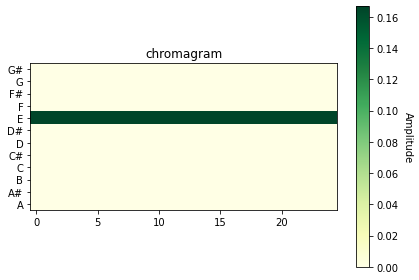

In [31]:
chromagram = getChromagram( features )
plotHeatmap( chromagram )

In [32]:
fileList = []

def getDataset( filePath ):
    X = pd.DataFrame(  )
    
    columns=[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    
    for root, dirs, filenames in os.walk( filePath ):
        for file in filenames:
            fileList.append( file )
            feature_name, features = preProcess(filePath + file )
            chromagram = getChromagram( features )
            noteFrequency = getNoteFrequency( chromagram )
            x_new =  pd.Series(noteFrequency[ 0, : ])
            X = pd.concat( [ X, x_new ], axis = 1 )
        
    data = X.T.copy()
    data.columns = columns
    data.index = [ i for i in range( 0, data.shape[ 0 ] ) ]
            
    return data

In [33]:
data = getDataset( "/content/drive/MyDrive/Tracks/" )

In [34]:
data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.161932,0.013482,0.079705,0.107771,0.143723,0.038284,0.124263,0.021092,0.089859,0.101899,0.071628,0.046360
1,0.054788,0.113543,0.067274,0.173619,0.153569,0.065291,0.031507,0.007932,0.082917,0.065217,0.039953,0.144389
2,0.160137,0.008676,0.059012,0.102978,0.174913,0.040667,0.152230,0.005061,0.057114,0.097058,0.087705,0.054449
3,0.171806,0.022302,0.054791,0.114537,0.161481,0.129405,0.082324,0.001790,0.066217,0.071724,0.026019,0.097605
4,0.061991,0.009753,0.072077,0.103474,0.227522,0.081096,0.085438,0.006613,0.081764,0.132999,0.105077,0.032198
5,0.037084,0.082952,0.088536,0.042354,0.026918,0.162452,0.275083,0.008596,0.052457,0.105541,0.060739,0.057288
6,0.059609,0.130442,0.097359,0.024399,0.031370,0.134637,0.286111,0.010575,0.072783,0.033674,0.048207,0.070834
7,0.154073,0.013978,0.019337,0.134193,0.242215,0.085812,0.075017,0.002951,0.082317,0.071756,0.029355,0.088996
8,0.030295,0.085080,0.109232,0.031894,0.032652,0.161323,0.259110,0.010688,0.067660,0.074140,0.049230,0.088698
9,0.154073,0.013823,0.019725,0.133261,0.252000,0.076338,0.071756,0.002718,0.084802,0.072222,0.029743,0.089539


In [42]:
# Number of cluster we wish to divide the data into( user tunable )
k = 9

# Max number of allowed iterations for the algorithm( user tunable )
epochs = 2000

In [43]:
def initilizeCentroids( data, k ):
    '''
    Initilize cluster centroids( assuming random k data points to be centroid return them )
    '''
    centroids = data[ 0 : k ]
    return centroids

In [44]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder( dtype = tf.float32 )
C = tf.placeholder( dtype = tf.float32 )
C_labels = tf.placeholder( dtype = tf.int32 )

# utility to assign centroids to examples
expanded_vectors = tf.expand_dims( X, 0 )
expanded_centroids = tf.expand_dims( C, 1 )
distance = tf.reduce_sum( tf.square( tf.subtract( expanded_vectors, expanded_centroids ) ), axis = 2 )
getCentroidsOp = tf.argmin( distance, 0 )


# utility to recalculate centroids
sums = tf.unsorted_segment_sum( X, C_labels, k )
counts = tf.unsorted_segment_sum( tf.ones_like( X ), C_labels, k  )
reCalculateCentroidsOp = tf.divide( sums,  counts )

In [45]:
centroids = []
data_labels = []

with tf.Session() as sess:
    
    # Initilize all tensor flow variables
    sess.run( tf.global_variables_initializer() )
    
    # Get initial list of k centroids
    centroids = initilizeCentroids( data, k )
    
    for epoch in range( epochs ):
        data_labels =  sess.run( getCentroidsOp, feed_dict = { X: data, C: centroids } )
        centroids = sess.run( reCalculateCentroidsOp, feed_dict = { X: data, C_labels: data_labels } )
    
print( data_labels )
print( centroids )

[0 1 2 3 4 5 6 7 8 7 1 4 2 8 3 5 6 0 4]
[[0.16151905 0.013482   0.07896299 0.10799381 0.1452389  0.03664095
  0.12417857 0.02064697 0.0911731  0.10182516 0.07135286 0.04698563]
 [0.05489865 0.11317568 0.06742068 0.1722973  0.15834312 0.0592685
  0.03308608 0.0073443  0.0835047  0.06595182 0.03899824 0.14571093]
 [0.16009218 0.00874339 0.05910262 0.10277439 0.17879897 0.03714247
  0.15078397 0.0049704  0.05824409 0.09753287 0.08693688 0.05487777]
 [0.17139317 0.02188877 0.05506608 0.11405562 0.16836454 0.12093888
  0.08204846 0.00199615 0.06724945 0.0726184  0.02594989 0.09843062]
 [0.06127812 0.00975284 0.07279003 0.10258295 0.23317747 0.0750835
  0.08508128 0.00643509 0.08091739 0.1342908  0.10547762 0.03313294]
 [0.03661291 0.08295162 0.08888122 0.04226015 0.03124804 0.15649119
  0.2760871  0.00862772 0.05295853 0.1052582  0.06073916 0.05788417]
 [0.05916583 0.13044249 0.09792048 0.02431027 0.03518048 0.12970403
  0.28655404 0.01042713 0.07310805 0.03393986 0.04773439 0.07151297]
 [0

In [46]:
final_labels = pd.DataFrame( { "Labels": data_labels, "File Names": fileList } )
final_labels

,Labels,File Names
0,0,Trac09d.mp3
1,1,Trac01d.mp3
2,2,Trac07d.mp3
3,3,Trac03d.mp3
4,4,Trac02d.mp3
5,5,Trac05d.mp3
6,6,Trac06d.mp3
7,7,Trac08d.mp3
8,8,Trac04d.mp3
9,7,Trac08.mp3
